# Libraries

In [23]:
import numpy as np
import matplotlib.pyplot as plt

# Quadrature Points

In [ ]:
quad_points = np.array([1/3, 1/3], [-1/3, 1/3], [-1/3, -1/3], [1/3, -1/3])
w = np.array([1,1])

# Shape Functions

In [ ]:
def evaluate_N(xi, eta):
    n = np.zeros(4)
    n[0] = (1+xi)*(1+eta)/4
    n[1] = (1-xi)*(1+eta)/4
    n[2] = (1-xi)*(1-eta)/4
    n[3] = (1+xi)*(1-eta)/4
    return n

def evaluate_dN_d_xi(xi, eta):
    v = np.zeros(4)
    v[0] = (1+eta)/4
    v[1] = (-1-eta)/4
    v[2] = (-1+eta)/4
    v[3] = (1-eta)/4
    return v

def evaluate_dN_d_eta(xi, eta):
    v = np.zeros(4)
    v[0] = (1+xi)/4
    v[1] = (1-xi)/4
    v[2] = (-1+xi)/4
    v[3] = (-1-xi)/4
    return v

# Shape Functions Evaluation

In [ ]:
for quad_point in quad_points:

# Classes

In [24]:
class Node:
    def __init__(self, id, x, y, ux=None, uy=None, rx=0, ry=0):
        self.id = id
        self.x  = x
        self.y  = y
        self.ux  = ux
        self.uy  = uy
        self.rx  = rx
        self.ry  = ry
    
    def __repr__(self):
        return f"Node({self.id}, x={self.x}, y={self.y}, ux={self.ux}, uy={self.uy}, rx={self.rx}, ry={self.ry})"

In [ ]:
class Element:
    def __init__(self, id, nodes):
        self.id = id
        self.nodes = nodes
    
    def coordinates(self):
        return np.array([(node.x, node.y) for node in self.nodes])

    def J(self, xi, eta):
        #define jacobian matrix at quadrature point i, j
        j = np.zeros([2,2])
        #get coordinates of the nodes 
        coords = self.coordinates()
        x = coords[:,0]
        y = coords[:,1]
        j[0][0] = np.dot(x,)


    # def __repr__(self):
    #     node_ids = [node.id for node in self.nodes]  
    #     return f"Element(id={self.id}, nodes={node_ids})"
    
    


    # def
    
    # def area(self):
    #     # Use stored coords
    #     area_array = np.array([
    #         [1, self.coords[0, 0], self.coords[0, 1]],
    #         [1, self.coords[1, 0], self.coords[1, 1]],
    #         [1, self.coords[2, 0], self.coords[2, 1]]
    #     ])
    #     return 0.5 * np.abs(np.linalg.det(area_array))
    
    # def B(self):
    #     b1 = self.coords[1, 1] - self.coords[2, 1]
    #     b2 = self.coords[2, 1] - self.coords[0, 1]
    #     b3 = self.coords[0, 1] - self.coords[1, 1]
    #     c1 = self.coords[2, 0] - self.coords[1, 0]
    #     c2 = self.coords[0, 0] - self.coords[2, 0]
    #     c3 = self.coords[1, 0] - self.coords[0, 0]
    #     return np.array([[b1, b2, b3], [c1, c2, c3]])
    
    # def localStiffnessMatrix(self):
    #     return k * 1 / (4 * self.area()) * self.B().T @ self.B()

In [46]:
class Mesh:
    def read_node_list(self, file_path):
        nodes = []
        node_section = False  # Flag to check if we are in the *Node section
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                # Check for the start of the *Node section
                if line.startswith('*Node'):
                    node_section = True
                    continue  # Skip the line that contains *Node header
                # Start of element section, stop reading node
                if node_section and line.startswith('*Element'): 
                    node_section = False
                    break
                # Skip the line if it is not a node data line
                if not line or line.startswith('*') or not line[0].isdigit():
                    continue
                # If we are in the *Node section, process the node data
                node_data = line.split(',')
                node_id = int(node_data[0].strip())
                x = float(node_data[1].strip())
                y = float(node_data[2].strip())
                # Create Node object and append to the list
                node = Node(node_id, x, y)
                nodes.append(node)
        return nodes
    
    def read_element_list(self, file_path):
        elements = []
        element_section = False  # Flag to check if we are in the *Element section
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                # Check for the start of the *Element section
                if line.startswith('*Element'):
                    element_section = True
                    continue  # Skip the line that contains *Element header
                # Stop reading elements
                if element_section and line.startswith('*Nset'): 
                    element_section = False
                    break
                # Skip the line if it is not an element data line
                if not line or line.startswith('*') or not line[0].isdigit() or not element_section:
                    continue
                # If we are in the *Element section, process the element data
                element_data = line.split(',')
                element_id = int(element_data[0].strip())
                nodes = []
                for i in range(1,5):
                    node_id = int(element_data[i].strip())
                    node_index = node_id - 1 #zero indexing shift
                    nodes.append(self.nodes[node_index]) 
                # Create Element object and append to the list
                element = Element(element_id, nodes)
                elements.append(element)
        return elements
    
    def __init__(self, file_path):
        self.nodes = self.read_node_list(file_path)
        self.elements = self.read_element_list(file_path)
    
    def plot_mesh(mesh, display_temp=False):
        plt.figure(figsize=(8, 6))
        
        # Plot each element
        for element in mesh.elements:
            # Get the coordinates of the nodes
            coords = np.array([(node.x, node.y) for node in element.nodes])
            # Close the polygon by appending the first node again
            coords = np.vstack([coords, coords[0]])
            plt.plot(coords[:, 0], coords[:, 1], marker='o')

        # #Plot boundary temperatures
        # if display_temp == True:
        #     for node_id, node in mesh.nodes.items():
        #         temp = node.T
        #         node = mesh.nodes[node_id]
        #         plt.text(node.x, node.y, f'T={temp:.3g}', fontsize=9, ha='right')

        # Set labels and title
        plt.title('Finite Element Mesh')
        plt.xlabel('x(m)')
        plt.ylabel('y(m)')
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# Mesh Generation

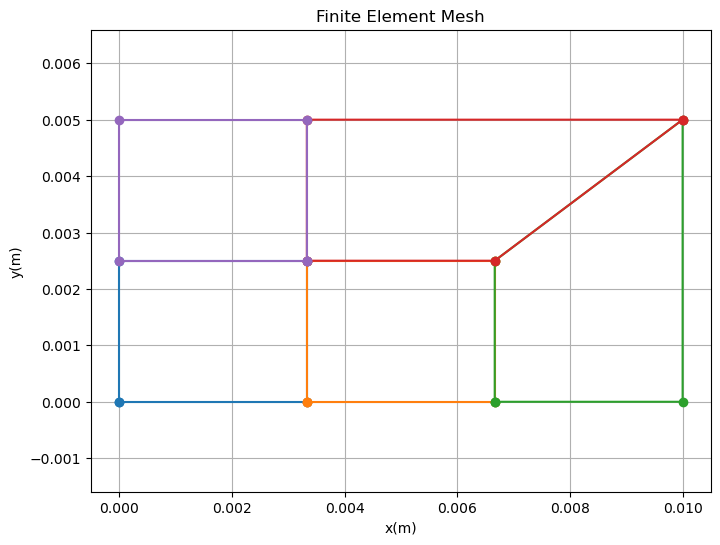

In [47]:
file_path = 'input.txt'  
mesh = Mesh(file_path)
mesh.plot_mesh()

In [50]:
element = mesh.elements[0]
coords = element.coordinates()
print(coords[0])

[0. 0.]


# Assembly

In [ ]:
#Global stiffness matrix and global load vector
K_global = np.zeros((n_nodes, n_nodes))
R_global = np.zeros(n_nodes)
N_local_nodes = 3
#loop over all elements
for element in mesh.elements.values():
    k_local = element.localStiffnessMatrix()
    local_indices = [node.id - 1 for node in element.nodes] #adjust for zero indexing of global matrix

    for i in range(N_local_nodes):
        for j in range(N_local_nodes):
            K_global[local_indices[i], local_indices[j]] += k_local[i,j]

# Boundary Conditions

In [ ]:
#Dirchlet
n_dirichlet_nodes = len(boundary_temperatures)
node_ids = np.arange(0, n_nodes)
dirchlet_node_ids =  np.array(list(boundary_temperatures.keys())) - 1  #adjust for zero indexing
non_dirichlet_node_ids = np.setdiff1d(node_ids, dirchlet_node_ids)
n_dirchlet_node_ids = len(dirchlet_node_ids)
n_interior_nodes = n_nodes - n_dirchlet_node_ids
#reducing global stiffness matrix
reduced_K_global = np.zeros((n_interior_nodes, n_interior_nodes))
temporary_K_global = np.delete(K_global, dirchlet_node_ids, 0) #remove rows
reduced_K_global = np.delete(temporary_K_global, dirchlet_node_ids, 1) #remove columns 
reduced_R_global = np.delete(R_global, dirchlet_node_ids)

R_modifier = np.zeros(n_nodes)
#modifying global load vector with boundary temperatures
for node_id, temperature in boundary_temperatures.items():
    node_id -= 1 #adjust for zero indexing
    R_modifier += K_global[:,node_id] * temperature

reduced_R_global -= np.delete(R_modifier, dirchlet_node_ids)

# Solve

In [ ]:
unkown_temperatures = np.linalg.solve(reduced_K_global, reduced_R_global) #solve for unkown temperatures
#construct full temperature vector
temperature = np.zeros(n_nodes)
i = 0
for node_id in non_dirichlet_node_ids:
    temperature[node_id] = unkown_temperatures[i]
    i += 1
#add boundary temperatures to full temperature vector
for node_id, boundary_temperature in boundary_temperatures.items():
    node_id -= 1 #adjust for zero indexing
    temperature[node_id] = boundary_temperature

for node in mesh.nodes.values():
    node.setTemperature(temperature[node.id-1])

# Output

Node ID    Temperature (degC)
-------------------------
1          200            
2          200            
3          200            
4          142            
5          142            
6          142            
7          142            
8          83.3           
9          83.3           
10         83.3           
11         25             
12         25             
13         25             
14         25             


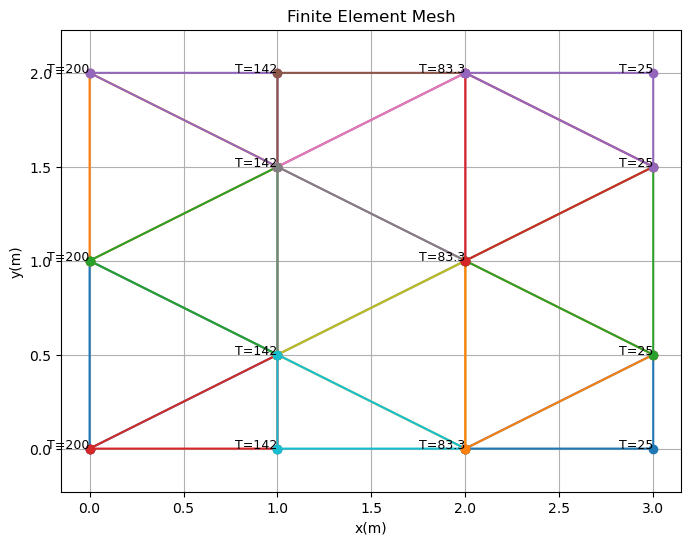

In [ ]:
print(f"{'Node ID':<10} {'Temperature (degC)':<15}")
print("-" * 25)
for node_id, node in mesh.nodes.items():
    temp_formatted = f"{mesh.nodes[node_id].T:.3g}"  # .3g for 3 significant figures
    print(f"{node_id:<10} {temp_formatted:<15}")
mesh.plot_mesh(display_temp=True)